# Lotto 5/35 Advanced

In [345]:
import time
from datetime import datetime
from typing import List, Optional, Tuple
import csv
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import itertools
from scipy.stats import norm
from itertools import permutations
import scipy.stats as stats
from tqdm import tqdm

from selenium import webdriver
from selenium.webdriver.chromium.webdriver import ChromiumDriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait, Select
from selenium.webdriver.support import expected_conditions as EC

from bs4 import BeautifulSoup, Tag

## Parameters

## Import libraries

In [346]:
URL = "https://www.minhchinh.com/thong-ke-lotto-535.html"
FROM_DATE = "01-01-2024"  # dd-MM-yyyy
TO_DATE = datetime.now().strftime("%d-%m-%Y")  # dd-MM-yyyy
FROM_DATE, TO_DATE

('01-01-2024', '22-02-2026')

In [347]:
LOTTO_5_35_FILE_NAME = "lotto_5_35"
LOTTO_5_35_CLEANED_FILE_NAME = "lotto_5_35_cleaned"

In [348]:
SCRAPER_BASE_WAIT_TIME = 1

## Helper functions

In [349]:
def update_bs4_parser(web_driver: ChromiumDriver) -> BeautifulSoup:
    return BeautifulSoup(web_driver.page_source, "html.parser")

In [350]:
def navigate_to_url(
    web_driver: ChromiumDriver, url: str
) -> Tuple[ChromiumDriver, BeautifulSoup]:
    print(f'Navigating to URL: "{url}"')
    web_driver.get(url)
    time.sleep(SCRAPER_BASE_WAIT_TIME)
    bs4_parser = update_bs4_parser(web_driver)

    return (web_driver, bs4_parser)

In [351]:
def input_text(web_driver: ChromiumDriver, xpath: str, value: str) -> None:
    input_element = WebDriverWait(web_driver, 10).until(
        EC.element_to_be_clickable((By.XPATH, xpath))
    )
    input_element.clear()
    input_element.send_keys(value)

In [352]:
def click_element(web_driver: ChromiumDriver, xpath: str) -> None:
    element = WebDriverWait(web_driver, 10).until(
        EC.element_to_be_clickable((By.XPATH, xpath))
    )
    element.click()

In [353]:
def extract_table(table: Optional[Tag]):
    # Extract headers
    headers = []
    thead = table.find("thead")
    if thead:
        header_row = thead.find_all("tr")[-1]  # use the last row if rowspan is present
        headers = [th.get_text(strip=True) for th in header_row.find_all("th")]

    # Extract rows
    rows = []
    tbody = table.find("tbody")
    for tr in tbody.find_all("tr"):
        # Skip group title rows
        if tr.get("class") and "group" in tr.get("class"):
            continue
        row = []
        for td in tr.find_all(["td"]):
            text = td.get_text(strip=True)
            row.append(text)
        rows.append(row)

    return (headers, rows)


def extract_table_by_class(
    bs4_parser: BeautifulSoup, class_name: str
) -> Tuple[List, List]:
    table = bs4_parser.find("table", class_=class_name)
    return extract_table(table)

## Start

### Scrape data from web

In [354]:
chrome_options = Options()
chrome_options.add_experimental_option(
    "prefs",
    {
        "profile.managed_default_content_settings.images": 2,  # Disable images
        "profile.managed_default_content_settings.stylesheets": 2,  # Disable CSS
        "profile.managed_default_content_settings.javascript": 1,  # Keep JS if needed
    },
)
chrome_options.add_argument(
    "user-agent=Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/123.0.0.0 Safari/537.36"
)

In [355]:
web_driver: ChromiumDriver = webdriver.Chrome(options=chrome_options)
bs4_parser: BeautifulSoup = BeautifulSoup(web_driver.page_source, "html.parser")
web_driver.maximize_window()

In [356]:
navigate_to_url(web_driver, URL)

from_date_xpath = '//*[@id="dateFromId"]'
to_date_xpath = '//*[@id="dateToId"]'
submit_button_xpath = '//*[@id="noidung"]/div[2]/div/div[1]/div/button'

click_element(web_driver, from_date_xpath)
input_text(web_driver, from_date_xpath, FROM_DATE)

click_element(web_driver, to_date_xpath)
input_text(web_driver, to_date_xpath, TO_DATE)

click_element(web_driver, submit_button_xpath)

time.sleep(SCRAPER_BASE_WAIT_TIME * 2)

bs4_parser = update_bs4_parser(web_driver)

Navigating to URL: "https://www.minhchinh.com/thong-ke-lotto-535.html"


In [357]:
table_class_name = "table-mini-result"

raw_table = extract_table_by_class(bs4_parser, table_class_name)

if len(raw_table):
    with open(
        f"{LOTTO_5_35_FILE_NAME}.csv", "w", newline="\n", encoding="utf-8"
    ) as file:
        writer = csv.writer(file)
        writer.writerows([raw_table[0]])
        writer.writerows(raw_table[1])

print(f"Data has been saved to '{LOTTO_5_35_FILE_NAME}.csv'")

web_driver.close()

Data has been saved to 'lotto_5_35.csv'


### Preprocess data

In [358]:
pandas_df = pd.read_csv(f"{LOTTO_5_35_FILE_NAME}.csv", dtype=str)

# Extract date and hour
pandas_df["date"] = pandas_df["NgàyMở Thưởng"].str.split().str[0]
pandas_df["hour"] = (
    pandas_df["NgàyMở Thưởng"].str.split().str[1].str.replace("h", "", regex=False)
)

# Split 12-digit result into 6 two-digit numbers
for i in range(6):
    col_name = f"x_{i+1}" if i < 5 else "x_s"
    pandas_df[col_name] = pandas_df["Kết Quả"].str[i * 2 : (i + 1) * 2]

# Clean prize (remove commas)
pandas_df["prize"] = pandas_df["Độc Đắc"].str.replace(",", "", regex=False)

# Keep only new columns
pandas_df = pandas_df[
    ["date", "hour", "x_1", "x_2", "x_3", "x_4", "x_5", "x_s", "prize"]
]

pandas_df

,date,hour,x_1,x_2,x_3,x_4,x_5,x_s,prize
0,21/02/26,21,02,16,17,20,31,01,7206575000
1,21/02/26,13,05,08,11,13,18,02,6992785000
2,20/02/26,21,01,09,18,28,33,07,6854822500
3,20/02/26,13,10,12,27,30,31,12,6727910000
4,19/02/26,21,09,21,23,25,29,03,6569592500
...,...,...,...,...,...,...,...,...,...
471,01/07/25,13,01,18,25,27,33,05,6676525000
472,30/06/25,21,01,12,13,27,28,07,6518352500
473,30/06/25,13,02,08,16,23,24,09,6315905000
474,29/06/25,21,06,12,14,18,25,08,6231295000


In [359]:
pandas_df.to_csv(f"{LOTTO_5_35_CLEANED_FILE_NAME}.csv", index=False)

### Read data

In [360]:
cleaned_df = pd.read_csv(f"{LOTTO_5_35_CLEANED_FILE_NAME}.csv")
cleaned_df

,date,hour,x_1,x_2,x_3,x_4,x_5,x_s,prize
0,21/02/26,21,2,16,17,20,31,1,7206575000
1,21/02/26,13,5,8,11,13,18,2,6992785000
2,20/02/26,21,1,9,18,28,33,7,6854822500
3,20/02/26,13,10,12,27,30,31,12,6727910000
4,19/02/26,21,9,21,23,25,29,3,6569592500
...,...,...,...,...,...,...,...,...,...
471,01/07/25,13,1,18,25,27,33,5,6676525000
472,30/06/25,21,1,12,13,27,28,7,6518352500
473,30/06/25,13,2,8,16,23,24,9,6315905000
474,29/06/25,21,6,12,14,18,25,8,6231295000


In [361]:
def make_centered_bins(min_value, n_bins, column_width):
    start = min_value - column_width / 2
    end = min_value + n_bins - 1 + column_width / 2
    return np.arange(start, end + column_width, column_width)


def plot_histograms(cleaned_df, column_width=0.5, mode="percentage"):
    """
    Plots histograms for predefined columns in cleaned_df.

    Parameters:
    - cleaned_df (pd.DataFrame): DataFrame containing the data
    - column_width (float): Width of histogram bins
    - mode (str): "percentage" or "count"
    """

    if mode not in ["percentage", "count"]:
        raise ValueError("mode must be 'percentage' or 'count'")

    columns = ["x_1", "x_2", "x_3", "x_4", "x_5", "x_s"]

    fig, axes = plt.subplots(3, 2, figsize=(30, 15), sharex=False)
    axes = axes.flatten()

    for i, col in enumerate(columns):

        if col not in cleaned_df.columns:
            raise ValueError(f"Column '{col}' not found in DataFrame")

        data = cleaned_df[col].astype(int)

        # Choose bin range
        if col == "x_s":
            bins = make_centered_bins(1, 12, column_width)
            xticks = range(1, 13)
        else:
            bins = make_centered_bins(1, 35, column_width)
            xticks = range(1, 36)

        # Apply weights only if percentage mode
        if mode == "percentage":
            weights = np.ones_like(data) * 100.0 / len(data)
            axes[i].hist(data, bins=bins, weights=weights)
            axes[i].set_ylabel("Percentage (%)")
        else:
            axes[i].hist(data, bins=bins)
            axes[i].set_ylabel("Count")

        axes[i].set_xticks(xticks)
        axes[i].set_title(col)
        axes[i].tick_params(axis="x", bottom=True, labelbottom=True)

    plt.tight_layout()
    plt.show()


def extended_summary(series):
    summary = {
        "Count": series.count(),
        "Mean": series.mean(),
        "Median": series.median(),
        "Mode": series.mode().iloc[0] if not series.mode().empty else None,
        "Std Dev": series.std(),
        "Variance": series.var(),
        "Min": series.min(),
        "Max": series.max(),
        "Skewness": series.skew(),
        "Kurtosis": series.kurt(),
        "Unique Values": series.nunique(),
    }

    return pd.DataFrame(summary, index=[series.name]).T

### Plot charts

In [362]:
# Plot config
plt.style.use("fivethirtyeight")
plt.rcParams["figure.figsize"] = (14, 6)
column_width = 0.5

In [363]:
cleaned_df

,date,hour,x_1,x_2,x_3,x_4,x_5,x_s,prize
0,21/02/26,21,2,16,17,20,31,1,7206575000
1,21/02/26,13,5,8,11,13,18,2,6992785000
2,20/02/26,21,1,9,18,28,33,7,6854822500
3,20/02/26,13,10,12,27,30,31,12,6727910000
4,19/02/26,21,9,21,23,25,29,3,6569592500
...,...,...,...,...,...,...,...,...,...
471,01/07/25,13,1,18,25,27,33,5,6676525000
472,30/06/25,21,1,12,13,27,28,7,6518352500
473,30/06/25,13,2,8,16,23,24,9,6315905000
474,29/06/25,21,6,12,14,18,25,8,6231295000


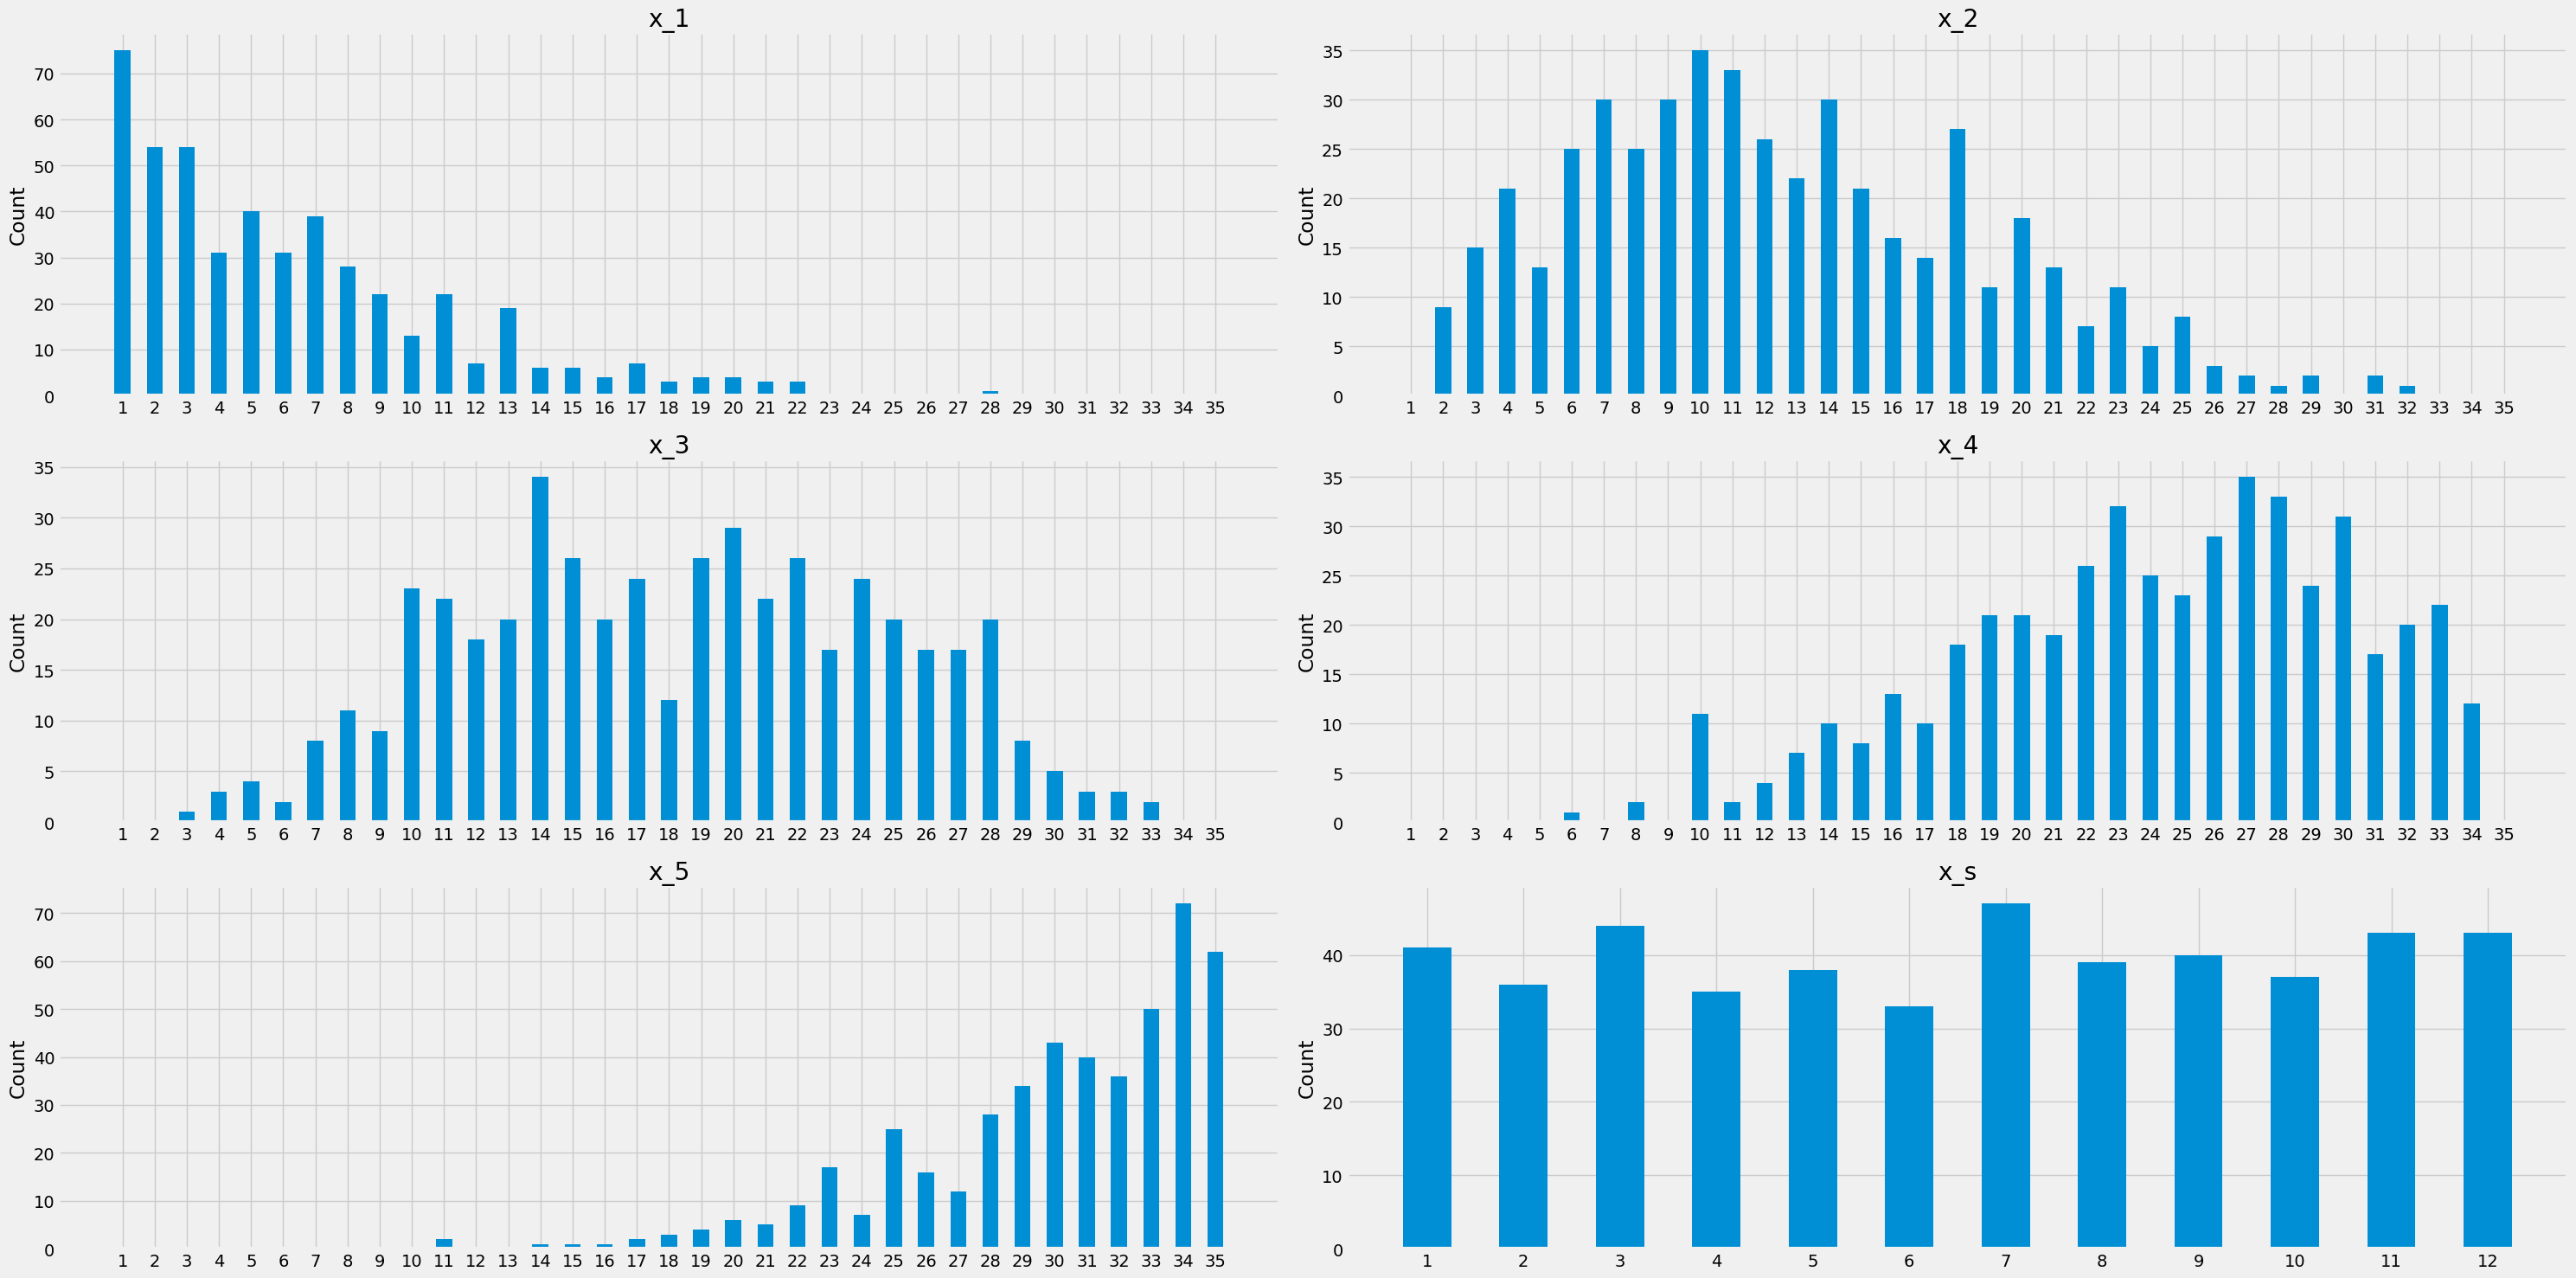

In [364]:
plot_histograms(cleaned_df, mode="count")

### Analysis data

#### Helper function

In [365]:
def plot_dictionary(data, color=None, title="Dictionary Values"):
    x = sorted(data.keys())
    y = [data[k] for k in x]

    plt.figure(figsize=(20, 6))
    plt.bar(x, y, color=color if color else None)

    plt.xlabel("Ball Number")
    plt.ylabel("Possibility")
    plt.title(title)

    plt.xticks(x)
    plt.ylim(0, 1)  # set y-axis range from 0 to 1
    plt.grid(True, axis="y", linestyle="--", alpha=0.5)

    plt.show()

In [366]:
def fit_and_select_distribution(
    data,
    distributions=[
        "geometric",
        "normal",
        "beta",
        "poisson",
        "exponential",
    ],
    index_range=(1, 35),  # NEW PARAMETER
):
    data = np.array(data)
    total_observations = len(data)

    # ---------------- INDEX RANGE ----------------
    if index_range is None:
        x_min = data.min()
        x_max = data.max()
    else:
        x_min, x_max = index_range

    x_vals = np.arange(x_min, x_max + 1)

    # Observed counts (missing indices automatically 0)
    observed_counts = np.array([np.sum(data == x) for x in x_vals])

    results = {}
    best_p_value = -np.inf
    best_expected_counts = None
    best_distribution = None

    for distribution in distributions:

        # ---------------- GEOMETRIC ----------------
        if distribution == "geometric":
            mean_x = np.mean(data)
            if mean_x <= 0:
                continue
            p_hat = 1 / mean_x
            expected_probs = stats.geom.pmf(x_vals, p_hat)

        # ---------------- NORMAL ----------------
        elif distribution == "normal":
            mean_x = np.mean(data)
            std_x = np.std(data, ddof=1)

            expected_probs = stats.norm.cdf(
                x_vals + 0.5, mean_x, std_x
            ) - stats.norm.cdf(x_vals - 0.5, mean_x, std_x)

        # ---------------- BETA ----------------
        elif distribution == "beta":
            min_val = data.min()
            max_val = data.max()
            scale_range = max_val - min_val

            if scale_range == 0:
                continue

            data_scaled = (data - min_val) / scale_range
            n = len(data_scaled)
            eps_data = (data_scaled * (n - 1) + 0.5) / n

            a, b, _, _ = stats.beta.fit(eps_data, floc=0, fscale=1)

            x_low = x_vals - 0.5
            x_high = x_vals + 0.5

            x_scaled_low = (x_low - min_val) / scale_range
            x_scaled_high = (x_high - min_val) / scale_range

            # outside [0,1] → zero probability
            outside_mask = (x_scaled_high <= 0) | (x_scaled_low >= 1)

            x_scaled_low = np.clip(x_scaled_low, 0, 1)
            x_scaled_high = np.clip(x_scaled_high, 0, 1)

            expected_probs = stats.beta.cdf(x_scaled_high, a, b) - stats.beta.cdf(
                x_scaled_low, a, b
            )

            expected_probs[outside_mask] = 0.0

        # ---------------- POISSON ----------------
        elif distribution == "poisson":
            lambda_hat = np.mean(data)
            expected_probs = stats.poisson.pmf(x_vals, lambda_hat)

        # ---------------- BINOMIAL ----------------
        elif distribution == "binomial":
            n_hat = int(np.max(data))
            if n_hat == 0:
                continue
            p_hat = np.mean(data) / n_hat
            expected_probs = stats.binom.pmf(x_vals, n_hat, p_hat)

        # ---------------- EXPONENTIAL ----------------
        elif distribution == "exponential":
            loc, scale = stats.expon.fit(data)

            expected_probs = stats.expon.cdf(
                x_vals + 0.5, loc, scale
            ) - stats.expon.cdf(x_vals - 0.5, loc, scale)

            # values below support → zero
            expected_probs[x_vals < loc] = 0.0

        else:
            raise ValueError(f"Unknown distribution: {distribution}")

        if expected_probs.sum() == 0:
            continue

        # Normalize
        expected_probs = expected_probs / expected_probs.sum()
        expected_counts = expected_probs * total_observations

        mask = expected_counts > 1e-8
        obs = observed_counts[mask]
        exp = expected_counts[mask]

        exp = exp * (obs.sum() / exp.sum())

        chi2_stat, p_value = stats.chisquare(f_obs=obs, f_exp=exp)
        results[distribution] = p_value

        if p_value > best_p_value:
            best_p_value = p_value
            best_expected_counts = expected_counts
            best_distribution = distribution

    return {
        "x_vals": x_vals,  # return full index range
        "observed_counts": observed_counts,
        "p_values": results,
        "best_distribution": best_distribution,
        "best_p_value": best_p_value,
        "expected_counts": best_expected_counts,
    }

#### Setting

In [367]:
# plot_dictionary(MAIN_POSSIBILITY_TABLE, title="Main Possibility Table")

In [368]:
# plot_dictionary(SPECIAL_POSSIBILITY_TABLE, title="Special Possibility Table")

In [387]:
SETTINGS = {
    "x_1": {"n_highest": 5, "n_outlier": 5},
    "x_2": {"n_highest": 5, "n_outlier": 5},
    "x_3": {"n_highest": 5, "n_outlier": 5},
    "x_4": {"n_highest": 5, "n_outlier": 5},
    "x_5": {"n_highest": 5, "n_outlier": 5},
}

In [388]:
ORIGINAL_PERMUTATIONS = [key for key in SETTINGS.keys() if key != "x_s"]
ORIGINAL_PERMUTATIONS

['x_1', 'x_2', 'x_3', 'x_4', 'x_5']

In [389]:
ALL_PERMUTATIONS = list(permutations(ORIGINAL_PERMUTATIONS))
len(ALL_PERMUTATIONS)

120

#### For loop

In [393]:
# MAIN_POSSIBILITY_TABLE
MAIN_POSSIBILITY_TABLE = pd.DataFrame(
    0.0, index=range(1, 36), columns=["x_1", "x_2", "x_3", "x_4", "x_5"]
)

# SPECIAL_POSSIBILITY_TABLE
SPECIAL_POSSIBILITY_TABLE = pd.DataFrame(0.0, index=range(1, 13), columns=["x_s"])

for i, per in enumerate(
    tqdm(ALL_PERMUTATIONS, desc="Processing permutations"), start=1
):

    transform_df = cleaned_df.copy()
    conditional_possibility = [1] + [0.0 for _ in range(len(ORIGINAL_PERMUTATIONS))]

    # Handle main balls
    for j, ball_column in enumerate(per, start=1):

        n_highest_threshold = SETTINGS[ball_column]["n_highest"]
        n_outlier_threshold = SETTINGS[ball_column]["n_outlier"]

        hist_data = np.bincount(transform_df[ball_column].values, minlength=36)[1:]
        data = np.repeat(
            list(range(1, 36)),
            hist_data,
        )
        total_observations = len(data)

        expected_counts = fit_and_select_distribution(data)["expected_counts"]

        # Find n highest values
        n_highest = np.argsort(hist_data)[-n_highest_threshold:][::-1] + 1

        # Find n outlier values
        valid_indices = np.where(hist_data > expected_counts)[0]
        n_outlier = (
            valid_indices[np.argsort(hist_data[valid_indices])[::-1]][
                :n_outlier_threshold
            ]
            + 1
        )

        final_balls = list(set(np.concatenate((n_highest, n_outlier))))

        final_count_dict = {}
        final_freq_dict = {}
        for ball in final_balls:
            final_count_dict[ball] = hist_data[ball - 1]
            final_freq_dict[ball] = hist_data[ball - 1] / total_observations

        conditional_possibility[j] = conditional_possibility[j - 1] * (
            sum(final_count_dict.values()) / total_observations
        )

        transform_df = transform_df[transform_df[ball_column].isin(final_balls)]
        for ball in final_balls:
            MAIN_POSSIBILITY_TABLE.loc[ball, ball_column] += final_freq_dict[ball]

    # Handle special ball
    n_highest_special_threshold = 5
    hist_data = np.bincount(transform_df["x_s"].values, minlength=13)[1:]
    data = np.repeat(
        list(range(1, 13)),
        hist_data,
    )
    total_observations = len(data)
    n_highest_special = np.argsort(hist_data)[-n_highest_special_threshold:][::-1] + 1

    final_balls = n_highest_special.copy()

    final_count_dict = {}
    final_freq_dict = {}
    for ball in final_balls:
        final_count_dict[ball] = hist_data[ball - 1]
        final_freq_dict[ball] = hist_data[ball - 1] / total_observations

    conditional_possibility[j] = conditional_possibility[j - 1] * (
        sum(final_count_dict.values()) / total_observations
    )

    for ball in final_balls:
        SPECIAL_POSSIBILITY_TABLE.loc[ball, "x_s"] += final_freq_dict[ball]

    transform_df = cleaned_df.copy()
    conditional_possibility = [1] + [0.0 for _ in range(len(ORIGINAL_PERMUTATIONS))]

    # Handle main balls
    for j, ball_column in enumerate(per, start=1):

        n_highest_threshold = SETTINGS[ball_column]["n_highest"]
        n_outlier_threshold = SETTINGS[ball_column]["n_outlier"]

        hist_data = np.bincount(transform_df[ball_column].values, minlength=36)[1:]
        data = np.repeat(
            list(range(1, 36)),
            hist_data,
        )
        total_observations = len(data)

        expected_counts = fit_and_select_distribution(data)["expected_counts"]

        # Find n highest values
        n_highest = np.argsort(hist_data)[-n_highest_threshold:][::-1] + 1

        # Find n outlier values
        valid_indices = np.where(hist_data > expected_counts)[0]
        n_outlier = (
            valid_indices[np.argsort(hist_data[valid_indices])[::-1]][
                :n_outlier_threshold
            ]
            + 1
        )

        final_balls = list(set(np.concatenate((n_highest, n_outlier))))

        final_count_dict = {}
        final_freq_dict = {}
        for ball in final_balls:
            final_count_dict[ball] = hist_data[ball - 1]
            final_freq_dict[ball] = hist_data[ball - 1] / total_observations

        conditional_possibility[j] = conditional_possibility[j - 1] * (
            sum(final_count_dict.values()) / total_observations
        )

        transform_df = transform_df[transform_df[ball_column].isin(final_balls)]
        for ball in final_balls:
            MAIN_POSSIBILITY_TABLE.loc[ball, ball_column] += final_freq_dict[ball]

    # Handle special ball
    n_highest_special_threshold = 5
    hist_data = np.bincount(transform_df["x_s"].values, minlength=13)[1:]
    data = np.repeat(
        list(range(1, 13)),
        hist_data,
    )
    total_observations = len(data)
    n_highest_special = np.argsort(hist_data)[-n_highest_special_threshold:][::-1] + 1

    final_balls = n_highest_special.copy()

    final_count_dict = {}
    final_freq_dict = {}
    for ball in final_balls:
        final_count_dict[ball] = hist_data[ball - 1]
        final_freq_dict[ball] = hist_data[ball - 1] / total_observations

    conditional_possibility[j] = conditional_possibility[j - 1] * (
        sum(final_count_dict.values()) / total_observations
    )

    for ball in final_balls:
        SPECIAL_POSSIBILITY_TABLE.loc[ball, "x_s"] += final_freq_dict[ball]

Processing permutations: 100%|██████████| 120/120 [00:03<00:00, 31.94it/s]


#### Plot MAIN_POSSIBILITY_TABLE

In [394]:
MAIN_POSSIBILITY_TABLE

,x_1,x_2,x_3,x_4,x_5
1,25.612005,0.000000,0.000000,0.000000,0.000000
2,17.902660,0.000000,0.000000,0.000000,0.000000
3,30.292266,0.000000,0.000000,0.000000,0.000000
4,1.518641,2.979588,0.000000,0.000000,0.000000
5,17.116834,0.355769,0.000000,0.000000,0.000000
6,7.870595,0.929208,0.000000,0.000000,0.000000
7,21.934594,8.211932,0.000000,0.000000,0.000000
8,16.394988,2.914436,0.336735,0.000000,0.000000
9,2.335361,11.863790,0.000000,0.000000,0.000000
10,1.036580,16.480289,3.375273,0.000000,0.000000


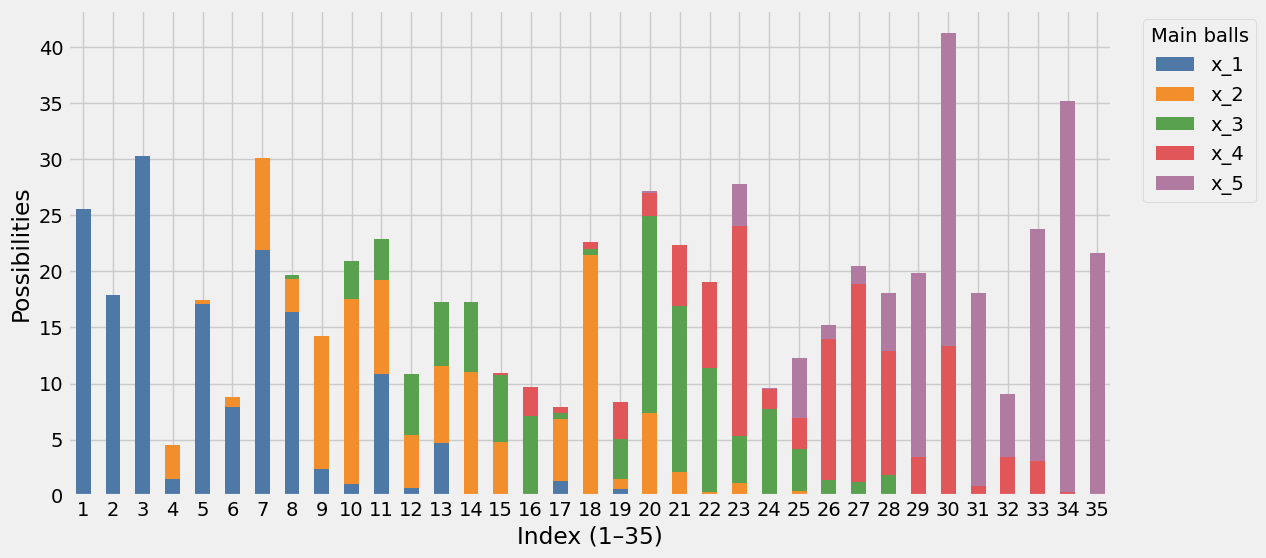

In [395]:
colors = ["#4E79A7", "#F28E2B", "#59A14F", "#E15759", "#B07AA1"]

ax = MAIN_POSSIBILITY_TABLE.plot(
    kind="bar", stacked=True, figsize=(12, 6), color=colors
)

ax.set_xlabel("Index (1–35)")
ax.set_ylabel("Possibilities")
ax.set_xticks(range(35))
ax.set_xticklabels(range(1, 36), rotation=0)

plt.legend(title="Main balls", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.show()

#### Plot SPECIAL_POSSIBILITY_TABLE

In [396]:
SPECIAL_POSSIBILITY_TABLE

,x_s
1,4.286773
2,9.010640
3,11.220664
4,20.156009
5,22.190080
6,13.440373
7,14.527163
8,4.992557
9,12.187471
10,5.449220


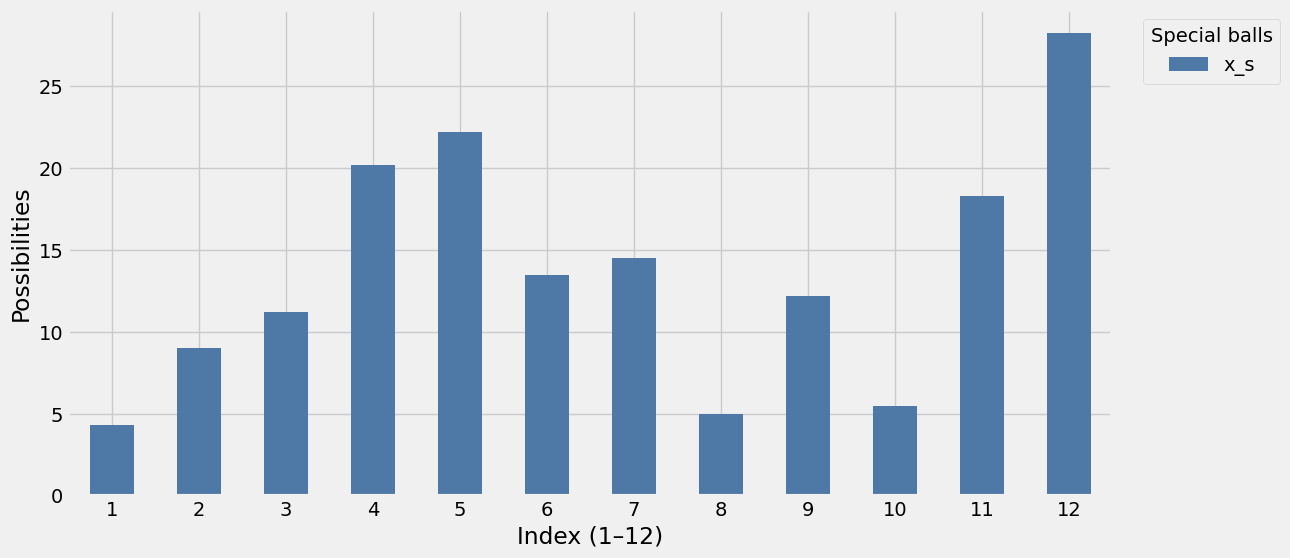

In [397]:
colors = ["#4E79A7", "#F28E2B", "#59A14F", "#E15759", "#B07AA1"]

ax = SPECIAL_POSSIBILITY_TABLE.plot(
    kind="bar", stacked=True, figsize=(12, 6), color=colors
)

ax.set_xlabel("Index (1–12)")
ax.set_ylabel("Possibilities")
ax.set_xticks(range(12))
ax.set_xticklabels(range(1, 13), rotation=0)

plt.legend(title="Special balls", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.show()

### Create result permutations

In [398]:
def create_ordered_permutations(ranges_dict, xs_values):
    # Separate ordered columns
    ordered_keys = list(ranges_dict.keys())
    ordered_values = list(ranges_dict.values())

    # Step 1: Generate strictly increasing combinations
    ordered_permutations = [
        p
        for p in itertools.product(*ordered_values)
        if all(p[i] < p[i + 1] for i in range(len(p) - 1))
    ]

    # Step 2: Add independent x_s column (Cartesian product)
    final_rows = [(*p, xs) for p in ordered_permutations for xs in xs_values]

    return pd.DataFrame(final_rows, columns=ordered_keys + ["x_s"])

In [399]:
ranges = {
    "x_1": MAIN_POSSIBILITY_TABLE["x_1"].nlargest(5).index,
    "x_2": MAIN_POSSIBILITY_TABLE["x_2"].nlargest(5).index,
    "x_3": MAIN_POSSIBILITY_TABLE["x_3"].nlargest(5).index,
    "x_4": MAIN_POSSIBILITY_TABLE["x_4"].nlargest(5).index,
    "x_5": MAIN_POSSIBILITY_TABLE["x_5"].nlargest(5).index,
}


xs = SPECIAL_POSSIBILITY_TABLE["x_s"].nlargest(5).index

In [400]:
output_df = create_ordered_permutations(ranges, xs)
output_df

,x_1,x_2,x_3,x_4,x_5,x_s
0,3,18,20,23,34,12
1,3,18,20,23,34,5
2,3,18,20,23,34,4
3,3,18,20,23,34,11
4,3,18,20,23,34,7
...,...,...,...,...,...,...
13770,5,11,16,28,31,12
13771,5,11,16,28,31,5
13772,5,11,16,28,31,4
13773,5,11,16,28,31,11


In [401]:
output_df.to_csv(f"lotto_5_35_permutations_advanced.csv", index=False, header=True)

In [402]:
df_a = cleaned_df.copy()
df_b = pd.DataFrame(output_df[["x_1", "x_2", "x_3", "x_4", "x_5", "x_s"]])

In [403]:
df_a

,date,hour,x_1,x_2,x_3,x_4,x_5,x_s,prize
0,21/02/26,21,2,16,17,20,31,1,7206575000
1,21/02/26,13,5,8,11,13,18,2,6992785000
2,20/02/26,21,1,9,18,28,33,7,6854822500
3,20/02/26,13,10,12,27,30,31,12,6727910000
4,19/02/26,21,9,21,23,25,29,3,6569592500
...,...,...,...,...,...,...,...,...,...
471,01/07/25,13,1,18,25,27,33,5,6676525000
472,30/06/25,21,1,12,13,27,28,7,6518352500
473,30/06/25,13,2,8,16,23,24,9,6315905000
474,29/06/25,21,6,12,14,18,25,8,6231295000


In [404]:
df_b

,x_1,x_2,x_3,x_4,x_5,x_s
0,3,18,20,23,34,12
1,3,18,20,23,34,5
2,3,18,20,23,34,4
3,3,18,20,23,34,11
4,3,18,20,23,34,7
...,...,...,...,...,...,...
13770,5,11,16,28,31,12
13771,5,11,16,28,31,5
13772,5,11,16,28,31,4
13773,5,11,16,28,31,11


In [405]:
common_rows = pd.merge(df_a, df_b)

common_rows

,date,hour,x_1,x_2,x_3,x_4,x_5,x_s,prize
0,27/11/25,21,1,10,16,30,34,7,6235762500
1,16/11/25,21,1,18,20,26,30,12,8212317500
2,13/11/25,13,7,9,21,27,30,4,6761012500
3,31/08/25,21,2,10,22,23,31,12,6457232500
4,19/08/25,13,3,10,24,30,33,4,6100900000
5,15/08/25,21,3,9,20,26,33,4,18934861000
6,01/07/25,21,5,18,20,30,34,7,6828647500


In [406]:
print("Existed: ", len(common_rows))
print("Existed percentage: ", len(common_rows) / len(df_a) * 100)

Existed:  7
Existed percentage:  1.4705882352941175
